# Importing Library

In [1]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install scikit-learn==1.2.2


In [3]:
!pip install -U datasets

# %%bash
!pip install torch_optimizer numpy torch transformers evaluate python-whois --quiet
# # The --quiet option is used to suppress the output of a pip command

In [4]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Import label encoder
from sklearn import preprocessing, metrics

import itertools
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, auc,roc_curve
from sklearn.model_selection import train_test_split
import random
import math
from collections import Counter
import xgboost as xgb
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import os
import socket
import whois
from datetime import datetime
import time
from bs4 import BeautifulSoup
import urllib
import bs4
import os

# Data Understanding

In [5]:
df = pd.read_csv('/content/malicious_phish.csv')

### Dataset Information

In [6]:
print(df.shape)
print(df.info())

(651191, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB
None


In [7]:
df.groupby('type').apply(lambda x: x.sample(1)).reset_index(drop=True)

,url,type
0,biz.yahoo.com/ic/836.html,benign
1,http://koronazrt.hu/index.php/hu/vegyesiparcik...,defacement
2,http://www.west263.com/services/domain/aprice_...,malware
3,www.sdl.sri.com/programs/intrusion/,phishing


In [8]:
df.isna().sum()

,0
url,0
type,0


### Data Distribution

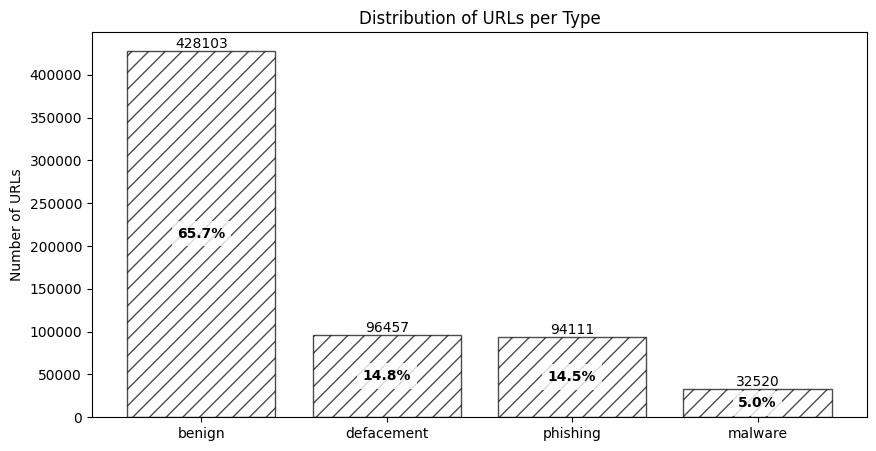

Counter({'benign': 428103, 'defacement': 96457, 'phishing': 94111, 'malware': 32520})


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

types = df['type'].values

counter_types = Counter(types)

type_names = list(counter_types.keys())
type_values = list(counter_types.values())

sorted_indices = np.argsort(type_values)[::-1]
type_names = [type_names[i] for i in sorted_indices]
type_values = [type_values[i] for i in sorted_indices]

total_count = sum(type_values)
percentages = [value / total_count * 100 for value in type_values]

pattern = '//'

y_pos = np.arange(len(type_names))
plt.figure(1, figsize=(10, 5))
bars = plt.bar(y_pos, type_values, align='center', alpha=0.7, color='none', edgecolor='black', hatch=pattern)

for bar, value, percentage in zip(bars, type_values, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{value}', ha='center', va='bottom')
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%', ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontweight='bold')

plt.xticks(y_pos, type_names)
plt.ylabel('Number of URLs')
plt.title('Distribution of URLs per Type')
plt.show()

print(counter_types)

In [10]:
df['url_len'] = [len(url) for url in df.url]
df.head()

,url,type,url_len
0,br-icloud.com.br,phishing,16
1,mp3raid.com/music/krizz_kaliko.html,benign,35
2,bopsecrets.org/rexroth/cr/1.htm,benign,31
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235


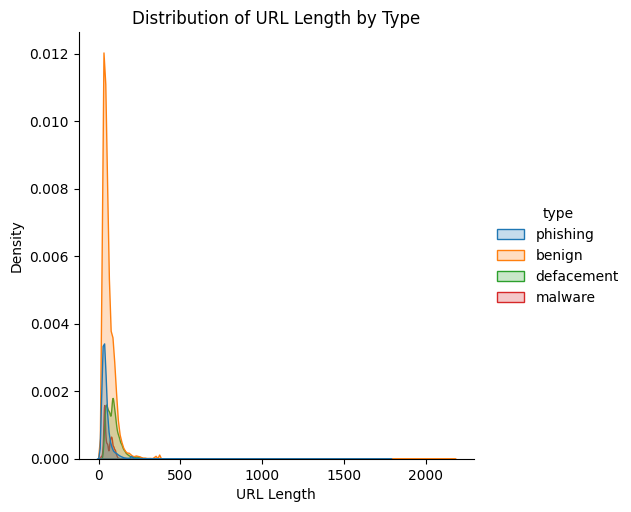

In [11]:
# Plot distribution of 'url_len' for each 'type'
sns.displot(df, x='url_len', hue='type', kind='kde', fill=True)

# Add labels and title
plt.xlabel('URL Length')
plt.ylabel('Density')
plt.title('Distribution of URL Length by Type')
plt.show()

# Data Preparation

## Label Encoding

In [12]:
print(df["type"].unique())  # Ensure there are no typos in labels


['phishing' 'benign' 'defacement' 'malware']


In [13]:
df["type"] = df["type"].replace("benig", "benign")


In [14]:
print(df["type"].unique())  # Ensure there are no typos in labels


['phishing' 'benign' 'defacement' 'malware']


In [15]:
from sklearn.preprocessing import LabelEncoder

le= LabelEncoder()
le.fit(df["type"])

df["type_code"] = le.transform(df["type"])
df

,url,type,url_len,type_code
0,br-icloud.com.br,phishing,16,3
1,mp3raid.com/music/krizz_kaliko.html,benign,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,31,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,88,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,235,1
...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,39,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,44,3
651188,www.gamespot.com/xbox360/action/deadspace/,phishing,42,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,45,3


In [16]:
le_label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_label_mapping

{'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}

### Splitting


In [17]:
df = df[['url', 'type', 'type_code']]
dataset = Dataset.from_pandas(df, preserve_index=False)
dataset

Dataset({
    features: ['url', 'type', 'type_code'],
    num_rows: 651191
})

In [18]:
# split train to 80% of total and test to 20% of total
train_test_dataset = dataset.train_test_split(test_size=0.2, seed=42, shuffle=True)
train_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 520952
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 130239
    })
})

In [19]:
# split the validation test to 10% of total and test set to 10% of total
val_test_dataset = train_test_dataset['test'].train_test_split(test_size=0.5, seed=42, shuffle=True)
val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65120
    })
})

In [20]:
from datasets import DatasetDict

# 80% train, 10% validation, 10% test
dataset = DatasetDict({
    'train': train_test_dataset['train'],
    'val': val_test_dataset['train'],
    'test': val_test_dataset['test'],
})
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'type_code'],
        num_rows: 65120
    })
})

### Importing Huggingface Data

In [21]:
dataset = load_dataset("bgspaditya/byt-mal-minpro")
dataset = dataset.rename_column("type_code", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65120
    })
})

In [22]:
dataset = load_dataset("bgspaditya/byt-mal-minpro")
dataset = dataset.rename_column("type_code", "labels")
dataset

DatasetDict({
    train: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 520952
    })
    val: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65119
    })
    test: Dataset({
        features: ['url', 'type', 'labels'],
        num_rows: 65120
    })
})

# Feature Engineering

In [23]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['val'])

# Feature Extraction

In [24]:
!pip install tld

In [25]:
import re
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df_train['use_of_ip'] = df_train['url'].apply(lambda i: having_ip_address(i))
df_test['use_of_ip'] = df_test['url'].apply(lambda i: having_ip_address(i))

from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df_train['abnormal_url'] = df_train['url'].apply(lambda i: abnormal_url(i))
df_test['abnormal_url'] = df_test['url'].apply(lambda i: abnormal_url(i))

df_train['count.'] = df_train['url'].apply(lambda i: i.count('.'))
df_test['count.'] = df_test['url'].apply(lambda i: i.count('.'))

df_train['count-www'] = df_train['url'].apply(lambda i: i.count('www'))
df_test['count-www'] = df_test['url'].apply(lambda i: i.count('www'))

df_train['count@'] = df_train['url'].apply(lambda i: i.count('@'))
df_test['count@'] = df_test['url'].apply(lambda i: i.count('@'))


from urllib.parse import urlparse
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df_train['count_dir'] = df_train['url'].apply(lambda i: no_of_dir(i))
df_test['count_dir'] = df_test['url'].apply(lambda i: no_of_dir(i))


def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df_train['count_embed_domian'] = df_train['url'].apply(lambda i: no_of_embed(i))
df_test['count_embed_domian'] = df_test['url'].apply(lambda i: no_of_embed(i))

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['sus_url'] = df_train['url'].apply(lambda i: suspicious_words(i))
df_test['sus_url'] = df_test['url'].apply(lambda i: suspicious_words(i))

def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

df_train['short_url'] = df_train['url'].apply(lambda i: shortening_service(i))
df_test['short_url'] = df_test['url'].apply(lambda i: shortening_service(i))

df_train['count-https'] = df_train['url'].apply(lambda i : i.count('https'))
df_test['count-https'] = df_test['url'].apply(lambda i : i.count('https'))

df_train['count-http'] = df_train['url'].apply(lambda i : i.count('http'))
df_test['count-http'] = df_test['url'].apply(lambda i : i.count('http'))



#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

df_train['count-'] = df_train['url'].apply(lambda i: i.count('-'))
df_test['count-'] = df_test['url'].apply(lambda i: i.count('-'))

df_train['count='] = df_train['url'].apply(lambda i: i.count('='))
df_test['count='] = df_test['url'].apply(lambda i: i.count('='))

df_train['url_length'] = df_train['url'].apply(lambda i: len(str(i)))
df_test['url_length'] = df_test['url'].apply(lambda i: len(str(i)))

df_train['hostname_length'] = df_train['url'].apply(lambda i: len(urlparse(i).netloc))
df_test['hostname_length'] = df_test['url'].apply(lambda i: len(urlparse(i).netloc))

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df_train['fd_length'] = df_train['url'].apply(lambda i: fd_length(i))
df_test['fd_length'] = df_test['url'].apply(lambda i: fd_length(i))


#Length of Top Level Domain
df_train['tld'] = df_train['url'].apply(lambda i: get_tld(i,fail_silently=True))
df_test['tld'] = df_test['url'].apply(lambda i: get_tld(i,fail_silently=True))

def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df_train['tld_length'] = df_train['tld'].apply(lambda i: tld_length(i))
df_test['tld_length'] = df_test['tld'].apply(lambda i: tld_length(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

df_train['count-digits']= df_train['url'].apply(lambda i: digit_count(i))
df_test['count-digits']= df_test['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

df_train['count-letters']= df_train['url'].apply(lambda i: letter_count(i))
df_test['count-letters']= df_test['url'].apply(lambda i: letter_count(i))

df_train['count%'] = df_train['url'].apply(lambda i: i.count('%'))
df_test['count%'] = df_test['url'].apply(lambda i: i.count('%'))
df_train

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-,count=,url_length,hostname_length,fd_length,tld,tld_length,count-digits,count-letters,count%
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,27,0,4,None,-1,4,19,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,10,0,0,None,-1,0,8,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,13,0,0,None,-1,0,11,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,3,0,68,19,18,dk,2,9,46,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,55,0,4,None,-1,8,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520947,kavasradiosoup.blogspot.com/2007/07/celeste-pe...,benign,0,0,0,3,0,0,3,0,...,7,0,80,0,4,None,-1,10,57,0
520948,http://mic.com/articles/117896/in-one-tweet-pr...,benign,0,0,1,1,0,0,3,0,...,12,0,100,7,8,com,3,6,75,0
520949,yelp.com/biz/kpix-tv-south-bay-bureau-san-jose,benign,0,0,0,1,0,0,2,0,...,6,0,46,0,3,None,-1,0,37,0
520950,http://torcache.net/torrent/D3123C9E5807875A84...,benign,0,0,1,7,0,0,2,0,...,0,1,123,12,7,net,3,33,74,0


In [26]:
df_train = df_train.drop("tld",axis=1)
df_test = df_test.drop("tld",axis=1)


In [27]:
df_train.head()

,url,type,labels,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count-,count=,url_length,hostname_length,fd_length,tld_length,count-digits,count-letters,count%
0,tools.ietf.org/html/rfc1328,phishing,3,0,0,2,0,0,2,0,...,0,0,0,27,0,4,-1,4,19,0
1,twnty.com/,benign,0,0,0,1,0,0,1,0,...,0,0,0,10,0,0,-1,0,8,0
2,pianoplus.ca/,benign,0,0,0,1,0,0,1,0,...,0,0,0,13,0,0,-1,0,11,0
3,http://www.fjordager-if.dk/aktivitetskalender/...,defacement,1,0,1,2,1,0,5,0,...,1,3,0,68,19,18,2,9,46,0
4,archives.cnn.com/2002/TECH/science/08/30/cools...,phishing,3,0,0,3,0,0,7,0,...,0,0,0,55,0,4,-1,8,37,0


# Data Splitting

In [28]:
df_train.columns

Index(['url', 'type', 'labels', 'use_of_ip', 'abnormal_url', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'sus_url',
       'short_url', 'count-https', 'count-http', 'count-', 'count=',
       'url_length', 'hostname_length', 'fd_length', 'tld_length',
       'count-digits', 'count-letters', 'count%'],
      dtype='object')

In [29]:
#Predictor Variables
X_train = df_train[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y_train = df_train['labels']

#Predictor Variables
X_test = df_test[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y_test = df_test['labels']

X_train.to_csv('./x-train.csv')
y_train.to_csv('./y-train.csv')
X_test.to_csv('./x-test.csv')
y_test.to_csv('./y-test.csv')

# Modeling

In [30]:
eval_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-macro', 'F1-micro', 'F1-weighted'])
eval_df

,Model,Accuracy,F1-macro,F1-micro,F1-weighted


## XGBoost

In [31]:
import xgboost as xgb  # Ensure correct import

xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)

y_predXGB = xgb_model.predict(X_test)

from sklearn import metrics
print(classification_report(y_test, y_predXGB))

score = metrics.accuracy_score(y_test, y_predXGB)
print("Accuracy: %0.3f" % score)

CM=confusion_matrix(y_test,y_predXGB,labels=[0,1,2,3])

print(CM)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.97      0.99      0.98      9557
           2       0.98      0.93      0.95      3253
           3       0.92      0.84      0.87      9359

    accuracy                           0.96     65120
   macro avg       0.96      0.94      0.95     65120
weighted avg       0.96      0.96      0.96     65120

Accuracy: 0.964
[[42419     8     2   522]
 [   19  9486     4    48]
 [   24    56  3024   149]
 [ 1250   230    50  7829]]


In [32]:
import pickle
# saving model
xgb_pkl = "xgb.pkl"
with open(xgb_pkl, 'wb') as file:
    pickle.dump(xgb_model, file)

## Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
y_predRF = rf.predict(X_test)
print(classification_report(y_test,y_predRF))

score = metrics.accuracy_score(y_test, y_predRF)
print("accuracy:   %0.3f" % score)
CM=confusion_matrix(y_test,y_predRF,labels=[0,1,2,3])

print(CM)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     42951
           1       0.98      1.00      0.99      9557
           2       0.99      0.95      0.97      3253
           3       0.91      0.86      0.89      9359

    accuracy                           0.97     65120
   macro avg       0.96      0.95      0.96     65120
weighted avg       0.97      0.97      0.97     65120

accuracy:   0.967
[[42307     1     3   640]
 [    4  9510     8    35]
 [   16    22  3084   131]
 [ 1085   161    26  8087]]


In [34]:
import pickle
# saving model
rf_pkl = "rf.pkl"
with open(rf_pkl, 'wb') as file:
    pickle.dump(rf, file)

In [35]:
print(rf)  # Ensure the model loads without errors


RandomForestClassifier(random_state=42)


In [36]:
import joblib

joblib.dump(rf, "rf.joblib")  # Save with joblib


['rf.joblib']

In [37]:
rf_small = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduce trees
rf_small.fit(X_train, y_train)

with open("rf_small.pkl", "wb") as file:
    pickle.dump(rf_small, file)


In [38]:
with open('le.pkl', 'wb') as file:
    pickle.dump(le, file)

# Real Time Detection System

In [39]:
import re
from urllib.parse import urlparse
from tld import get_tld
import numpy as np

def extract_features(url):
    features = []
    features.append(having_ip_address(url))
    features.append(abnormal_url(url))
    features.append(url.count('.'))
    features.append(url.count('www'))
    features.append(url.count('@'))
    features.append(no_of_dir(url))
    features.append(no_of_embed(url))
    features.append(shortening_service(url))
    features.append(url.count('https'))
    features.append(url.count('http'))
    features.append(url.count('%'))
    features.append(url.count('-'))
    features.append(url.count('='))
    features.append(len(url))
    features.append(len(urlparse(url).netloc))
    features.append(suspicious_words(url))
    features.append(fd_length(url))
    tld = get_tld(url, fail_silently=True)
    features.append(tld_length(tld))
    features.append(digit_count(url))
    features.append(letter_count(url))
    return np.array(features).reshape(1, -1)

def detect_url(url, model):
    features = extract_features(url)
    prediction = model.predict(features)
    predicted_class_name = le.inverse_transform([prediction[0]])[0]  # Convert number to class name
    return predicted_class_name

# Example usage:
url = "http://example.com/login"
predicted_class = detect_url(url, rf)
print(f"The URL is classified as: {predicted_class}")


The URL is classified as: phishing


In [40]:
# Example usage:
url = "mp3raid.com/music/krizz_kaliko.html"
predicted_class = detect_url(url, rf)
print(f"The URL is classified as: {predicted_class}")

The URL is classified as: benign


In [41]:
# Example usage:
url = "xbox360.ign.com/objects/850/850402.html"
predicted_class = detect_url(url, rf)
print(f"The URL is classified as: {predicted_class}")

The URL is classified as: phishing


In [42]:
import sklearn
print(sklearn.__version__)

1.2.2
